In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import higher
import matplotlib.pyplot as plt
from tqdm import tqdm
from models.simple_mnist import MNISTModel

In [2]:
BATCH_SIZE = 256
DEVICE = "cpu"  # change if you have a gpu

In [3]:
class ForwardWeight(nn.Module):
    """
    Wrapper for models to simplify reassigning the weights to a specified distribution
    """
    def __init__(self, model, distribution):
        super().__init__()
        self.model = model
        self.distribution = distribution

    def init_weights(self, layer):
        if isinstance(layer, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)):
            nn.init.zeros_(layer.bias)
            self.distribution(layer.weight)

    def new_weights(self):
        self.model.apply(self.init_weights)

    def forward(self, x):
        return self.model(x)

In [4]:
def train_distilled_images(model, dataloader, M, distribution, gd_steps, init_lr, loss_fn, device="cpu"):
    """
    Parameters:
        model: The model for which we wish to distill images
        dataloader: The DataLoader for the dataset we wish to distill (per class)
        M: The number of examples to distill down to
        distribution: The initial distribution of weights, p(theta_0)
        gd_steps: The number of gradient descent steps
        init_lr: The initial learning rate
        loss_fn: The loss function
        device: Defaults to the CPU
    """
    _, *img_shape = dataloader.dataset[0][0].shape

    x_distilled = torch.rand(M * 10, *img_shape, requires_grad=True, device=device)
    # TODO: Generalize this to any output shape
    y_distilled = torch.arange(10, device=device).repeat(10)

    model = ForwardWeight(model, distribution).to(DEVICE)
    model_opt = torch.optim.Adam(model.parameters(), lr=init_lr)
    lr = higher.optim.get_trainable_opt_params(model_opt)["lr"][0]
    opt = torch.optim.AdamW([x_distilled, lr])
    for x_batch, y_batch in tqdm(dataloader, total=len(dataloader)):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        loss = torch.tensor(0., device=device)
        for _ in range(dataloader.batch_size):
            # The model with its weights sampled from the provided distribution, p(theta_0)
            model.new_weights()
            with higher.innerloop_ctx(model, model_opt, override={"lr": [lr]}) as (fmodel, diffopt):
                fmodel = fmodel.to(device)
                # Line 6 gradient descent
                for _ in range(gd_steps):
                    diffopt.step(loss_fn(fmodel(x_distilled), y_distilled))
                # Line 7 gradient accumulation
                loss += loss_fn(fmodel(x_batch), y_batch)
        with torch.no_grad():
            opt.zero_grad()
            loss.backward()
            opt.step()
        higher.optim.apply_trainable_opt_params(model_opt, {"lr": [lr]})
    return x_distilled, lr

In [5]:
train_dataloader = DataLoader(
    datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=transforms.ToTensor()
    ),
    batch_size=BATCH_SIZE
)

test_dataloader = DataLoader(
    datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=transforms.ToTensor()
    ),
    batch_size=BATCH_SIZE
)

In [6]:
distilled, lr = train_distilled_images(
    model=MNISTModel(),
    dataloader=train_dataloader,
    M=10,
    distribution=nn.init.xavier_uniform_,  # we use the glorot uniform distribution for our weights as the paper does
    gd_steps=1,  # increasing this will improve the distilled images
    init_lr=0.01,
    loss_fn=nn.CrossEntropyLoss(),
)

100%|██████████| 235/235 [09:06<00:00,  2.33s/it]


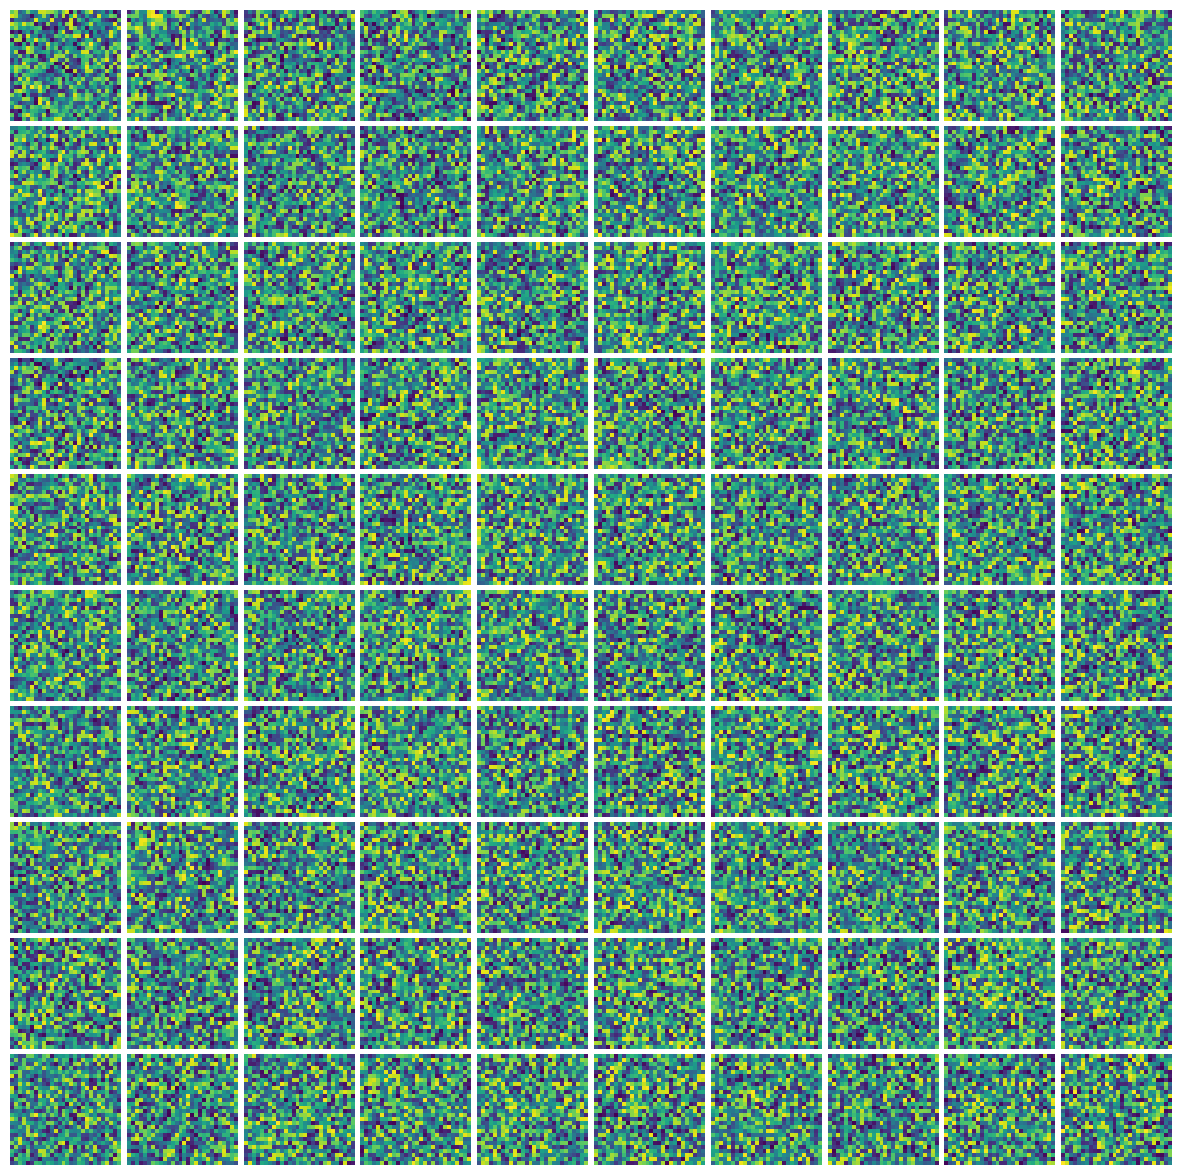

In [7]:
_, axs = plt.subplots(10, 10, figsize=(15, 15))
axs = axs.flatten()
for img, ax in zip(distilled.detach().numpy(), axs):
    ax.imshow(img)
    ax.axis("off")
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [13]:
model = MNISTModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X, y

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X, y
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [14]:
# train our mnist model on the distilled images
epochs = 75
dataset_loader = DataLoader(TensorDataset(distilled, torch.arange(10).repeat(10)))
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(dataset_loader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.296473  [    0/  100]
Test Error: 
 Accuracy: 9.0%, Avg loss: 2.304592 

Epoch 2
-------------------------------
loss: 2.282802  [    0/  100]
Test Error: 
 Accuracy: 9.1%, Avg loss: 2.304130 

Epoch 3
-------------------------------
loss: 2.267627  [    0/  100]
Test Error: 
 Accuracy: 9.2%, Avg loss: 2.303704 

Epoch 4
-------------------------------
loss: 2.257119  [    0/  100]
Test Error: 
 Accuracy: 9.3%, Avg loss: 2.303261 

Epoch 5
-------------------------------
loss: 2.251184  [    0/  100]
Test Error: 
 Accuracy: 9.5%, Avg loss: 2.302782 

Epoch 6
-------------------------------
loss: 2.248702  [    0/  100]
Test Error: 
 Accuracy: 9.6%, Avg loss: 2.302303 

Epoch 7
-------------------------------
loss: 2.241515  [    0/  100]
Test Error: 
 Accuracy: 9.8%, Avg loss: 2.301857 

Epoch 8
-------------------------------
loss: 2.234593  [    0/  100]
Test Error: 
 Accuracy: 9.9%, Avg loss: 2.301416 

Epoch 9
------------------------